## Загрузка данных

In [1]:
import pandas as pd 

fold = pd.read_csv("./Data/fold.csv")
unfold = pd.read_csv("./Data/unfold.csv")

profile = pd.read_csv("./Data/profile.csv")

delayexp = pd.read_csv("./Data/delayexp.csv")

delay_fig4 = pd.read_csv("./Data/delay_fig4.csv")
plotmat_fig4 = pd.read_csv("./Data/plotmat_fig4.csv")
plotmat2_fig4 = pd.read_csv("./Data/plotmat2_fig4.csv")

delay_fig5 = pd.read_csv("./Data/delay_fig5.csv")
plotmat_fig5 = pd.read_csv("./Data/plotmat_fig5.csv")
plotmat2_fig5 = pd.read_csv("./Data/plotmat2_fig5.csv")

## Базовая модель кабеля

Здесь мы проверяем теорию о профиле возмущения в пассивном волокне, вызванном потенциалом действия в соседнем волокне.

In [2]:
N = fold.shape[0]

#m - миелин
#n - Ранвье
d = 3
lambm = 1.3794*d
lambn = 0.055*(d**0.5) 
taum = 0.47
taun = 0.03
deltaL = 0.01 #отношение длины длины перехвата Рванье к длине миелинизированного участка. 
#lambm - пространственная постоянная длины миелинизированного сегмента
#lambn - пространственная постоянная длины узла Ранвье.
#taum и taun - соотвнтсвенно 

Постоянные времени и пространства: 

In [3]:
lambhom = ((1-deltaL)*(1/lambm**2) + deltaL*(1/lambn**2))**(-1/2) #постоянная длины для всего аксона (7)
tauhom = lambhom**2*((1-deltaL)*(taum/lambm**2) + deltaL*(taun/lambn**2)) #времени длины для всего аксона (8)

Параметры для вычиления градиента потенциала в пространстве ((5) вторая производная потеницала):

In [4]:
c = 3.1; #скорость распространения всплеска
sigrat = 1/3; #внеклеточная проводимость/аксональная проводимость
rho = 0.3; #плотность аксонов
g = 0.6; # общая проводимость 
pre = -(1/(1+d**2))/(1+sigrat*((1-rho)/(g**2*rho))); 

Скорость экспоненциального изменения импульса мембраны для + и - заряда (22):

In [5]:
scale = 10
lamb1 = (0.5 * ( c**2*tauhom**2+4*lambhom**2)**0.5 - 0.5*c*tauhom)*scale
lamb2 = (0.5 * ( c**2*tauhom**2+4*lambhom**2)**0.5 + 0.5*c*tauhom)*scale

Ядро свертки (21):

In [6]:
lamb3 = lambhom**2 / (4*lambhom**2 + c**2*tauhom**2)**0.5 * scale

In [7]:
import numpy as np

fold2 = np.zeros((fold.shape[0], fold.shape[1]))
fold3 = fold2
fold4 = fold2

In [8]:
fold2.shape

(1099, 1)

In [9]:
x = np.arange(-N/2+1/2, N/2-1/2, 1) 
x

array([-549., -548., -547., ...,  546.,  547.,  548.])

In [10]:
x2 = np.concatenate((x, [0]))
x2 = np.sort(x2)
np.where(x2 == 0)

(array([549, 550], dtype=int64),)

Кусочно-экспоненциальная функция ядра (17, но без * вторую производную ɸ):

In [11]:
kernel = lamb3*( np.exp(x/lamb2)*(x<0) + np.exp(-x/lamb1)*(x>0) )

lamb3: Масштабирующий коэффициент (амплитуда).
exp(x2./lamb2).*(x2<0): Экспоненциальный рост для x < 0.
exp(-x2./lamb1).*(x2>=0): Экспоненциальное затухание для x ≥ 0.

Второе ядро отслеживающее изменение мембранного потенциала (17, но без * вторую производную ɸ): 

In [12]:
kernel2 = lamb3*( np.exp(x2/lamb2)*(x2<0) + np.exp(-x2/lamb1)*(x2>=0) )

In [13]:
unfold_array = unfold.iloc[:, 0].values 
unfold_array = np.concatenate(([float(unfold.columns[0])], unfold_array))
unfold_fft = np.fft.fft(unfold_array)
kernel_fft = np.fft.fft(kernel)

unfold_fft = unfold_fft[:-2] 
multiplied_fft = unfold_fft * kernel_fft
inverse_fft = np.fft.ifft(multiplied_fft)

foldk = np.real(np.fft.ifftshift(inverse_fft)) 

## Графики

Сравнение возмущения в пассивном аксоне, полученного численно, с биофизической моделью и свертка аналитически полученного интегрального ядра со второй производной численно полученного профиля спайка: 

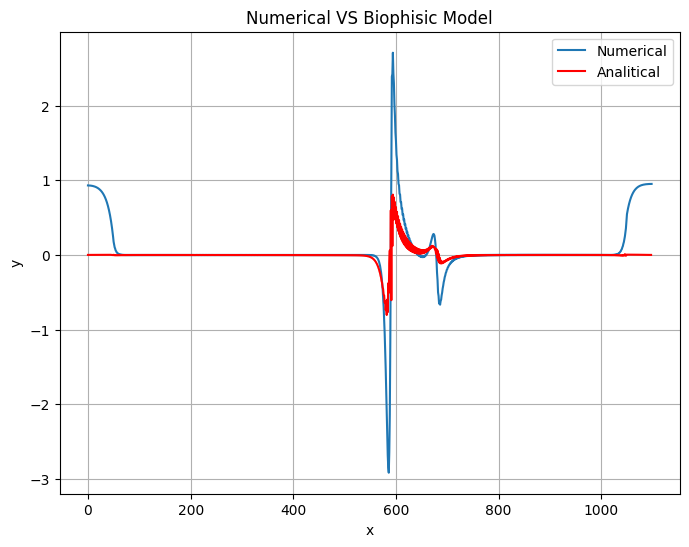

In [14]:
import matplotlib.pyplot as plt

fold_gp = fold.to_numpy()
plt.figure(figsize=(8,6)) 
plt.plot(fold_gp[::-1] - fold_gp[799]) 
plt.plot(pre * foldk[::-1], 'r')  
plt.xlabel("x")
plt.ylabel("y")
plt.title("Numerical VS Biophisic Model")
plt.legend(["Numerical", "Analitical"])
plt.grid(True) 
plt.show()

Возмущение в пассивном аксоне может быть описано сверткой кривизны профиля спайка и асимметричного ядра. Профиль спайка в определенный момент времени, вычисленный численно с использованием биофизической модели (раздел 2.5). Профиль является репрезентативным для всех стадий распространения спайка: 

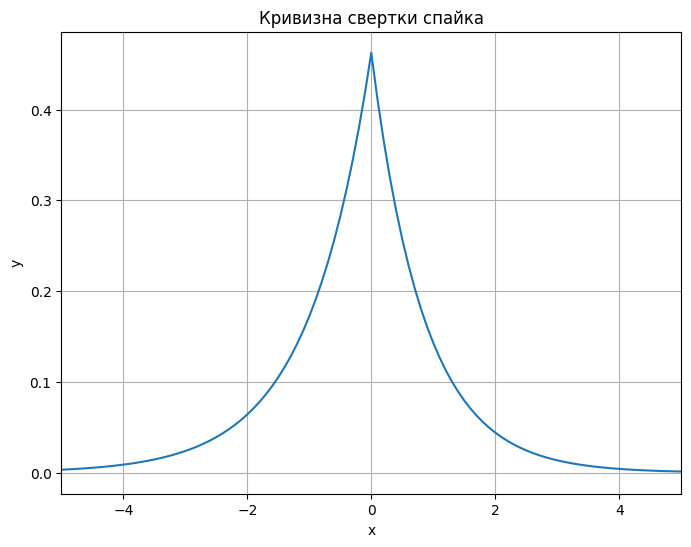

In [15]:
plt.figure(figsize=(8,6))
plt.plot(x2 / scale, kernel2 / scale)
plt.xlim([-5, 5])
plt.xlabel("x") 
plt.ylabel("y")
plt.title("Кривизна свертки спайка")
plt.grid(True) 
plt.show()

Функция модели:

In [16]:
def fCable_eph_theor_2(d):
    N = fold.shape[0]

    #m - миелин
    #n - Ранвье
    lambm = 1.3794*d
    lambn = 0.055*(d**0.5) 
    taum = 0.47
    taun = 0.03
    deltaL = 0.01 #отношение длины длины перехвата Рванье к длине миелинизированного участка. 
    #lambm - пространственная постоянная длины миелинизированного сегмента
    #lambn - пространственная постоянная длины узла Ранвье.
    #taum и taun - соотвнтсвенно 
    lambhom = ((1-deltaL)*(1/lambm**2) + deltaL*(1/lambn**2))**(-1/2) #постоянная длины для всего аксона (7)
    tauhom = lambhom**2*((1-deltaL)*(taum/lambm**2) + deltaL*(taun/lambn**2)) #времени длины для всего аксона (8)

    c = 3.1; #скорость распространения всплеска
    sigrat = 1/3; #внеклеточная проводимость/ксональная проводимость
    rho = 0.3; #плотность аксонов
    g = 0.6; # общая проводимость 
    pre = -(1/(1+d**2))/(1+sigrat*((1-rho)/(g**2*rho))); 

    scale = 10
    lamb1 = (0.5 * ( c**2*tauhom**2+4*lambhom**2)**0.5 - 0.5*c*tauhom)*scale
    lamb2 = (0.5 * ( c**2*tauhom**2+4*lambhom**2)**0.5 + 0.5*c*tauhom)*scale
    lamb3 = lambhom**2 / (4*lambhom**2 + c**2*tauhom**2)**0.5 * scale

    fold2 = np.zeros((fold.shape[0], fold.shape[1]))
    fold3 = fold2
    fold4 = fold2

    x = np.arange(-N/2+1/2, N/2-1/2, 1)
    x2 = np.concatenate((x, [0]))
    x2 = np.sort(x2)

    kernel = lamb3*( np.exp(x/lamb2)*(x<0) + np.exp(-x/lamb1)*(x>0) )
    kernel2 = lamb3*( np.exp(x2/lamb2)*(x2<0) + np.exp(-x2/lamb1)*(x2>=0) )

    unfold_array = unfold.iloc[:, 0].values 
    unfold_array = np.concatenate(([float(unfold.columns[0])], unfold_array))
    unfold_fft = np.fft.fft(unfold_array)
    kernel_fft = np.fft.fft(kernel)

    unfold_fft = unfold_fft[:-2] 
    multiplied_fft = unfold_fft * kernel_fft
    inverse_fft = np.fft.ifft(multiplied_fft)

    foldk = np.real(np.fft.ifftshift(inverse_fft)) 

    minVp = np.min(pre * foldk[::-1]) 

    return minVp

Профиль асимметричного ядра:

C:\Users\LKDat\AppData\Local\Temp\ipykernel_3460\3939116551.py:36: RuntimeWarning: overflow encountered in exp
  kernel = lamb3*( np.exp(x/lamb2)*(x<0) + np.exp(-x/lamb1)*(x>0) )
C:\Users\LKDat\AppData\Local\Temp\ipykernel_3460\3939116551.py:36: RuntimeWarning: invalid value encountered in multiply
  kernel = lamb3*( np.exp(x/lamb2)*(x<0) + np.exp(-x/lamb1)*(x>0) )
C:\Users\LKDat\AppData\Local\Temp\ipykernel_3460\3939116551.py:37: RuntimeWarning: overflow encountered in exp
  kernel2 = lamb3*( np.exp(x2/lamb2)*(x2<0) + np.exp(-x2/lamb1)*(x2>=0) )
C:\Users\LKDat\AppData\Local\Temp\ipykernel_3460\3939116551.py:37: RuntimeWarning: invalid value encountered in multiply
  kernel2 = lamb3*( np.exp(x2/lamb2)*(x2<0) + np.exp(-x2/lamb1)*(x2>=0) )


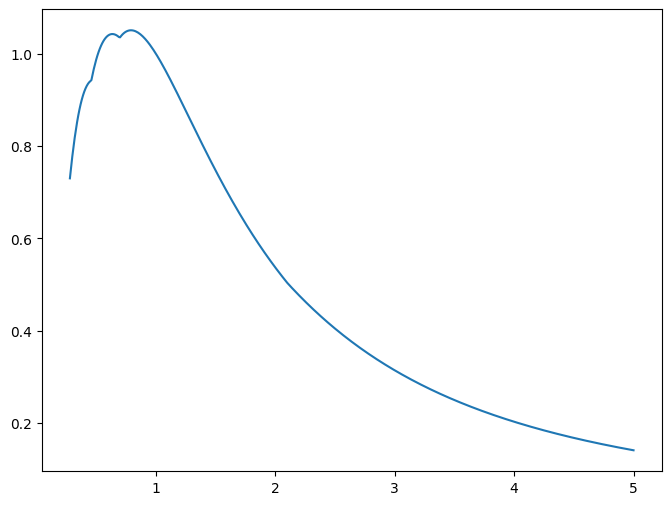

In [22]:
x = np.arange(0.2, 5.01, 0.01)
y = np.array([fCable_eph_theor_2(val) for val in x])

index_near_one = np.argmin(np.abs(x - 1))
y_normalized = y / y[index_near_one]

plt.figure(figsize=(8, 6)) 
plt.plot(x, y_normalized)